# External datasets: retrieval and preprocessing

In [4]:
# required libraries
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import requests, zipfile, io
import openpyxl
import ssl
from urllib.request import urlopen, Request

In [7]:
ssl._create_default_https_context = ssl._create_unverified_context

Set up directories used in this notebook for data retrival and storage.

In [11]:
output_relative_dir = '../data/landing/'
target_dir = '../data/landing'
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)

In [12]:
output_relative_dir = '../data/raw/'
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)

In [13]:
output_relative_dir = '../data/landing/'
target_dir = "sa2_zones"
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

In [3]:
output_relative_dir = '../data/landing/'
target_dir = "sa2_data"
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

In [14]:
output_relative_dir = '../data/landing/'
target_dir = "postalArea"
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

In [15]:
output_relative_dir = '../data/raw/'
target_dir = "sa2_data"
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

In [16]:
output_relative_dir = '../data/raw/'
target_dir = "addedInfo_transaction"
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

## 1. SA2 District Boundaries (shape file)

SA2 (Statistical Area Level 2)is a medium sized geographical areas defined by the Australian Bureau of Statistics (ABS) for statistical purposes. Census data is provided by ABS for each SA2, which is going to be utilized in this project.

The SA2 boundaries as shape file was obtained from the link below.

source: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

In [5]:
# retrive SA2 boundary data from the url above.
zip_file_url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA2_2021_AUST_SHP_GDA2020.zip"
output_dir = '../data/landing/sa2_zones/'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
# save to the directory
z.extractall(output_dir)

In [29]:
sf1 = gpd.read_file("../data/landing/sa2_zones/SA2_2021_AUST_GDA2020.shp")
SA2_list = list(set(sf1['SA2_CODE21']))
len(SA2_list)

2473

## 2. Tbl consumer dataset

TBL consumer dataset provides information about all the consumers, including their name, address, postcode, etc.

The addresses are not real but the postcodes are, therefore postcode will be used to merge this consumer dataset to the external datasets obtained in the following sections.

In [34]:
# obtain the consumer dataset and show the first 3 rows
tbl_consumer = pd.read_csv("../data/tables/tbl_consumer.csv", sep='|')
tbl_consumer.head(3)

,name,address,state,postcode,gender,consumer_id
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
1,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
2,Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530


## 3. SA2 income data

Income data such as median income, sum income for each SA2 is provided in census data by ABS. Those data were obtained from the link below.

Source: https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/personal-income-australia/latest-release

In [8]:
# retrive income data from the url above, then save to directry
url = "https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/personal-income-australia/2015-16-2019-20/6524055002_DO001.xlsx"
output_dir = '../data/landing/sa2_data/sa2_income.xlsx'
urlretrieve(url, output_dir)

('../data/landing/sa2_data/sa2_income.xlsx',
 <http.client.HTTPMessage at 0x17276e090>)

### 3. i) Drop unnecessary rows and columns

In [12]:
# read in the income data
sa2_income = pd.read_excel("../data/landing/sa2_data/sa2_income.xlsx", sheet_name=f'Table 1.4')
# drop unnecessary rows
sa2_income = sa2_income.drop([0,1,2,3,4,5]).reset_index(drop=True)
sa2_income = sa2_income.drop(sa2_income.tail(3).index)
# extract only the columns of interest and rename them for readability
sa2_income = sa2_income[['            Australian Bureau of Statistics', 'Unnamed: 1', 'Unnamed: 6', 'Unnamed: 11', 'Unnamed: 16', 'Unnamed: 21', 'Unnamed: 26']]
new_column_names = ['sa2_code2016', 'sa2_name2016', 'num_earners','medianAge_earners', 'sum_income', 'median_income', 'mean_income']
sa2_income.columns = new_column_names
# drop rows with Nan values which are the invalid rows (not missing values)
sa2_income = sa2_income.dropna()

In [13]:
sa2_income

,sa2_code2016,sa2_name2016,num_earners,medianAge_earners,sum_income,median_income,mean_income
2,101021007,Braidwood,2426,50,149794037,44246,61745
3,101021008,Karabar,5128,42,345342749,62946,67345
4,101021009,Queanbeyan,6778,39,455997821,61724,67276
5,101021010,Queanbeyan - East,3360,40,241148449,64010,71770
6,101021011,Queanbeyan Region,13502,44,1151756047,74042,85303
...,...,...,...,...,...,...,...
2292,801101137,Molonglo,np,np,np,np,np
2293,801101138,Molonglo - North,np,np,np,np,np
2294,801101139,Wright,2226,35,193715001,80498,87024
2295,801111140,ACT - South West,354,40,27364728,68987,77301


### 3. ii) Convert from SA2_2016 to SA2_2021

SA2 has changed from 2016 to 2021 and its discrepancies can cause conflicts in further merging steps.

The income data we have is using 2016 SA2 representation, but we aim to convert this into 2021 representation.

We got the dataset for the correspondences from the source below.

Source: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/correspondences

In [15]:
# get the correspondences data from the url above and save to directry
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/correspondences/CG_SA2_2016_SA2_2021.csv"
output_dir = '../data/landing/sa2_2016_2021.csv'
urlretrieve(url, output_dir)

('../data/landing/sa2_2016_2021.csv', <http.client.HTTPMessage at 0x1727b33d0>)

In [20]:
# read in the correspondences data
sa2_2016_2021 = pd.read_csv('../data/landing/sa2_2016_2021.csv')
# extract only the columns of interest
sa2_2016_2021 = sa2_2016_2021[['SA2_MAINCODE_2016', 'SA2_CODE_2021', 'SA2_NAME_2021']]

In [21]:
# Some SA2 from 2016 doesn't exist at 2021
sa2_2016_2021[sa2_2016_2021.isnull().any(axis=1)]

,SA2_MAINCODE_2016,SA2_CODE_2021,SA2_NAME_2021
638,128011531.0,NaN,NaN
2283,604031094.0,NaN,NaN
2503,NaN,ZZZZZZZZZ,Outside Australia


In [22]:
# for every SA2_2021, we want the corresponding SA2_2016 representation and the income data
sa2_income_2021 = pd.merge(sa2_2016_2021, sa2_income, left_on='SA2_MAINCODE_2016', right_on='sa2_code2016', how = "left")

# not all the SA2s were registered in income data, remove missing values from merging
sa2_income_2021 = sa2_income_2021.dropna()

# drop SA2 representation in 2016 since we are using SA2 representation in 2021 for further steps
sa2_income_2021 = sa2_income_2021.drop(['SA2_MAINCODE_2016', 'sa2_code2016', 'sa2_name2016'], axis=1)

# some SA2_2021 are linked with multiple SA2_2016 -> drop the duplicates
sa2_income_2021 = sa2_income_2021.drop_duplicates(subset='SA2_CODE_2021')


In [26]:
# These missing values are mostly because not all the SA2 income data were available in the dataset
# sa2_income_2021[sa2_income_2021.isnull().any(axis=1)].head(5)

In [23]:
sa2_income_2021.head(5)

,SA2_CODE_2021,SA2_NAME_2021,num_earners,medianAge_earners,sum_income,median_income,mean_income
0,101021007,Braidwood,2426,50,149794037,44246,61745
1,101021008,Karabar,5128,42,345342749,62946,67345
2,101021009,Queanbeyan,6778,39,455997821,61724,67276
3,101021010,Queanbeyan - East,3360,40,241148449,64010,71770
4,101021610,Googong,13502,44,1151756047,74042,85303


### 3. iii) Values with 'np' (not published)

The value 'np' in this dataset means that the data is not published to protect the confidentiality of individuals or businesses.

48 SA2s (rows) out of 2473 are having 'np' values.

We decided to impute these with median instead of removing to retain sample size.

In [31]:
# numbers of SA2s with 'np' values
sa2_income_2021[sa2_income_2021.eq('np').any(axis=1)].shape

(48, 7)

-> total of 48 SA2 (as defined in 2021) are misssing income data due to privacy concerns.

In [35]:
# replace the value "np" with Nan for convenience
sa2_income_2021 = sa2_income_2021.replace('np', np.NaN)

# add 2 SA2s that are included in tbl consumer dataset but not present in our income dataset,
#  for the ease of merging between these 2 datasets in later steps.
new_row = pd.DataFrame({'SA2_CODE_2021': '901011001', 'SA2_NAME_2021': 'Christmas Island'}, index=[0])
new_row2 = pd.DataFrame({'SA2_CODE_2021': '901021002', 'SA2_NAME_2021': 'Cocos (Keeling) Islands'}, index=[0])
sa2_income_2021 = pd.concat([new_row,sa2_income_2021.loc[:]]).reset_index(drop=True)
sa2_income_2021 = pd.concat([new_row2,sa2_income_2021.loc[:]]).reset_index(drop=True)

In [36]:
sa2_income_2021[sa2_income_2021.isnull().any(axis=1)].shape

(50, 7)

Check distribution of each numerical features to see that median is representitive of the dataset and therefore appropriate for missing values imputation.

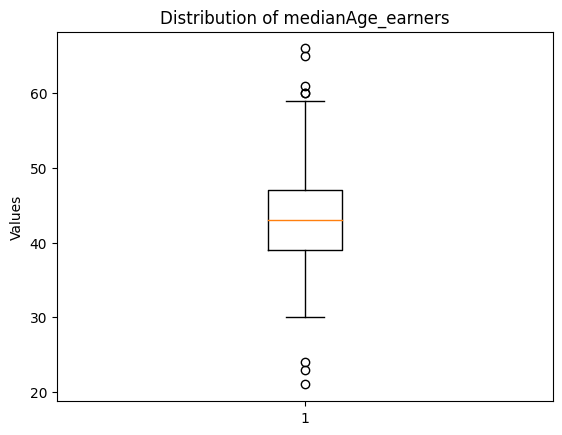

In [41]:
# plot boxplot of the attribute 'medianAge_earners'
lst = list(sa2_income_2021['medianAge_earners'])
filtered_lst = [x for x in lst if str(x) != 'nan']
plt.boxplot(filtered_lst)
plt.title('Distribution of medianAge_earners')
plt.ylabel('Values')
plt.show()

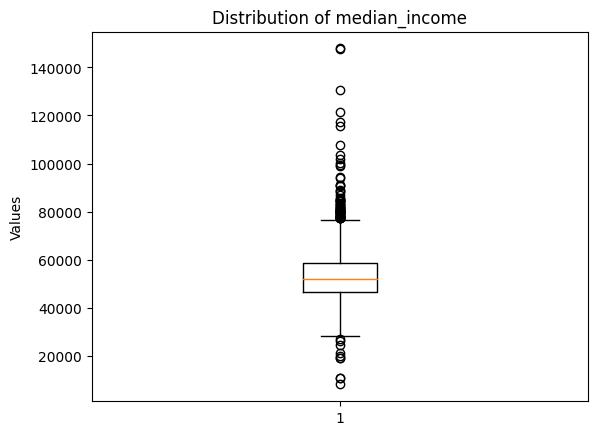

In [42]:
# plot boxplot of the attribute 'median_income'
lst = list(sa2_income_2021['median_income'])
filtered_lst = [x for x in lst if str(x) != 'nan']
plt.boxplot(filtered_lst)
plt.title('Distribution of median_income')
plt.ylabel('Values')
plt.show()

In [43]:
sa2_income_imputed = sa2_income_2021.copy()
# features with missing values (and therefore want to impute)
nan_columns = ['num_earners', 'medianAge_earners', 'sum_income', 'median_income', 'mean_income']
for feature in nan_columns:
    # for each feature, calculate median and impute Nan values with that value
    median = sa2_income_imputed[feature].median()
    sa2_income_imputed[feature].fillna(median, inplace=True)

In [44]:
sa2_income_imputed.to_csv(r'../data/raw/sa2_data/sa2_income_imputed.csv', index=False)

## 4. Get SA2 demographic data

Demographic data such as population, population density can be obtained for each SA2 from the census data by ABS.

The data was obtained from the link below.

source: https://www.abs.gov.au/statistics/people/population/regional-population/latest-release

In [45]:
# retrieve  data from the above url and save to directory
url = "https://www.abs.gov.au/statistics/people/population/regional-population/2021-22/32180DS0001_2021-22.xlsx"
output_dir = output_relative_dir + 'sa2_data/sa2_population.xlsx'
urlretrieve(url, output_dir)

('../data/landing/sa2_data/sa2_population.xlsx',
 <http.client.HTTPMessage at 0x172db1d10>)

### Preprocess demographic data

Since the data were spread on 10 different pages in xlsx file, data from each page were processed separately via iteration as follows.

In [46]:
# Data from each page were accessed via iteration, then processed and saved to the following dictionary.
sa2_population_dict = {}
new_column_names = ['S/T code', 'S/T name', 'GCCSA code','GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', '2021ERP', '2022ERP','ERPchange#', 'ERPchange%', 'Area', 'popDensity2022']
subset_columns = ['SA2 code', 'SA2 name', '2021ERP', '2022ERP','ERPchange#', 'ERPchange%', 'Area', 'popDensity2022']
for i in range(1, 10):
    # read in the demographic data in page i
    sa2_population = pd.read_excel("../data/landing/sa2_data/sa2_population.xlsx", sheet_name=f'Table {str(i)}')
    # drop empty rows and columns
    sa2_population = sa2_population.drop([0,1,2,3,4,5,7]).reset_index(drop=True)
    sa2_population = sa2_population.drop(['Unnamed: 12', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'], axis=1)
    # rename the columns
    sa2_population.columns = new_column_names
    # drop few more rows without data
    sa2_population = sa2_population.drop([0]).reset_index(drop=True)
    sa2_population = sa2_population.drop(sa2_population.tail(7).index)
    # extract features of interest
    sa2_population = sa2_population[subset_columns]
    # save into dictionary
    sa2_population_dict[i] = sa2_population

In [48]:
# merge all the data from different page into one dataframe
for i in range(1, 10):
    if i==1:
        concat_df = sa2_population_dict[i]
    else:
        concat_df = pd.concat([sa2_population_dict[i], concat_df], axis=0)

In [51]:
# demographic data for all the SA2s
len(concat_df)

2454

In [92]:
concat_df.to_csv(r'../data/raw/sa2_data/sa2_population.csv', index=False)

## 5. Australian postcodes

As mentioned earlier, postcodes in tbl consumer dataset will be used to merge it with the external datasets obtained above, which are in SA2 units. 

We used spatial join to make correspondencies between SA2 boundaries and postcodes.

The location of all the postcodes in Australia was obtained from the link below.

Source: https://www.matthewproctor.com/australian_postcodes#downloadlinks

In [52]:
# retrive postcode data from the above url and save to the directory
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}
url = "https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv"
output_dir = '../data/landing/postCode_sa2Code.csv'
r = requests.get(url, headers=headers,allow_redirects=True)
open(output_dir, 'wb').write(r.content)

7764836

### 6. i) preprocess postcode data

In [53]:
# read in postcode data
postcode_sa2 = pd.read_csv('../data/landing/postCode_sa2Code.csv')

# extract the columns of interest
postCode = postcode_sa2[['postcode', 'lat', 'long']]

# remove the duplicate rows
postCode_2 = postCode.drop_duplicates(
  subset = ['postcode'],
  keep = 'last').reset_index(drop = True)

There are 6 postcodes in the dataset with invalid location of longtitude=latitude=0.

After checking that there are no tbl consumers with those postcodes, we removed those entries.

In [103]:
# postcodes with invalid location: long=lat=0
postCode_2[postCode_2.eq(0).any(axis=1)]

,postcode,lat,long
3,803,0.0,0.0
238,1405,0.0,0.0
313,1874,0.0,0.0
2508,5801,0.0,0.0
3158,8438,0.0,0.0
3159,8511,0.0,0.0


In [54]:
# check that those postcodes with invalid locations are not included in tbl consumer dataset
print(803 in list(set(tbl_consumer['postcode'])))
print(1405 in list(set(tbl_consumer['postcode'])))
print(1874 in list(set(tbl_consumer['postcode'])))
print(5801 in list(set(tbl_consumer['postcode'])))
print(8438 in list(set(tbl_consumer['postcode'])))
print(8511 in list(set(tbl_consumer['postcode'])))

False
False
False
False
False
False


In [56]:
# remove those postcodes with invalid location from the dataset
null_postcode = [803, 1405, 1874, 5801, 8438, 8511]
postCode_3 = postCode_2[~postCode_2['postcode'].isin(null_postcode)]

Also, we found that postcode '2755' is not included in our postcode dataset while there are tbl consumers with this postcode.

Since the location of this postcode could be easily obtained from google map, we manually added that postcode as a new entry.

In [57]:
# add the data entry for missing post code, 2755 which exists in tbl consumer dataset but not in our postcode dataset
# The postcode 2755 corresponds to Richmond, New South Wales.
new_row = pd.DataFrame({'postcode': 2755, 'lat':-33.597328, 'long':150.755451}, index=[0])
postCode_4 = pd.concat([new_row,postCode_3.loc[:]]).reset_index(drop=True)

In [58]:
# save the cleaned postcode dataset
postCode_4.to_csv(r'../data/raw/postCode.csv', index=False)

### 6. ii) Spatial join between postcodes and SA2 zones

Spatial join was done by identifying SA2 that contains the point in location of each postcode, obtained from the above dataset.

Some postcodes were having point of location showing ocean (coastal areas, etc), while there postcode could not be merged with SA2 in the above method.

For those postcodes, nearest SA2 zone was identified.

In [60]:
# read in the shape file of SA2 boundaries
sf1 = gpd.read_file("../data/landing/sa2_zones/SA2_2021_AUST_GDA2020.shp")

# geodataframe of SA2 boundaries
sf1['geometry'] = sf1['geometry'].to_crs("EPSG:4326")

# make another geodataframe of postcodes with point in location as 'geometry' column
gdf = gpd.GeoDataFrame(
    postCode_4, geometry=gpd.points_from_xy(postCode_4.long, postCode_4.lat), crs="EPSG:4326"
)
gdf.set_geometry("geometry")

,postcode,lat,long,geometry
0,2755,-33.597328,150.755451,POINT (150.75545 -33.59733)
1,200,-35.277700,149.118900,POINT (149.11890 -35.27770)
2,800,-12.458684,130.836680,POINT (130.83668 -12.45868)
3,801,-12.458684,130.836680,POINT (130.83668 -12.45868)
4,804,-12.428017,130.873315,POINT (130.87331 -12.42802)
...,...,...,...,...
3163,9013,-27.603479,152.823141,POINT (152.82314 -27.60348)
3164,9015,-27.603479,152.823141,POINT (152.82314 -27.60348)
3165,9464,-27.397055,153.074982,POINT (153.07498 -27.39706)
3166,9726,-28.008783,153.412197,POINT (153.41220 -28.00878)


In [61]:
# spatial join between SA2s and postcodes
join=gpd.sjoin(gdf, sf1, how='left',predicate='intersects')

# retain only the necessary columns
postcode_sa2 = join[['postcode', 'SA2_CODE21', 'SA2_NAME21']]

In [62]:
# check that the postcode is linked with the corresponding SA2 zone
postcode_sa2[500:510]

,postcode,SA2_CODE21,SA2_NAME21
500,2206,119021662,Earlwood
501,2207,119041669,Bexley - North
502,2208,119041377,Kingsgrove (South) - Bardwell Park
503,2209,119031370,Narwee - Beverly Hills
504,2210,119031372,Peakhurst - Lugarno
505,2211,119011358,Padstow
506,2212,119011360,Revesby
507,2213,119011658,Panania (South) - Picnic Point
508,2214,119011657,Panania (North) - Milperra
509,2216,119041381,Rockdale - Banksia


In [64]:
# some postcodes didn't get merged properly with SA2 zones
missed_postcode = list(set(postcode_sa2[postcode_sa2.isnull().any(axis=1)]['postcode']))
gdf_missed = gdf[gdf['postcode'].isin(missed_postcode)]
gdf_missed

,postcode,lat,long,geometry
317,2000,-33.859953,151.256649,POINT (151.25665 -33.85995)
361,2047,-33.853924,151.165735,POINT (151.16574 -33.85392)
392,2083,-33.525322,151.194452,POINT (151.19445 -33.52532)
531,2256,-33.482123,151.331154,POINT (151.33115 -33.48212)
541,2267,-33.086545,151.591728,POINT (151.59173 -33.08655)
544,2281,-33.089963,151.668857,POINT (151.66886 -33.08996)
708,2502,-34.494723,150.873081,POINT (150.87308 -34.49472)
709,2505,-34.466406,150.943899,POINT (150.94390 -34.46641)
1657,3921,-38.419488,145.367079,POINT (145.36708 -38.41949)
1688,3960,-39.140761,146.360412,POINT (146.36041 -39.14076)


In [66]:
# The above 22 postcodes didn't intersect with SA2 zones because the point in latitude and longtitude were in ocean 
# (slightly off from land)
# thus use sjoin_nearest instead to join those postcode with SA2
join_2=gpd.sjoin_nearest(gdf_missed, sf1, how='left')
postcode_sa2_2 = join_2[['postcode', 'SA2_CODE21', 'SA2_NAME21']]

# replace nan entries with the newly joined entires with sjoin_nearest
postcode_sa2_3 = postcode_sa2.dropna()
postcode_sa2_4 = pd.concat([postcode_sa2_3, postcode_sa2_2])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [68]:
postcode_sa2_4.to_csv(r'../data/raw/postCode_sa2.csv', index=False)

## 7. Merge tbl consumer data and demographic, income datasets

In [69]:
# read in all the datasets ready to merge
sa2_population = pd.read_csv('../data/raw/sa2_data/sa2_population.csv')
postCode_sa2 = pd.read_csv(r'../data/raw/postCode_sa2.csv')
tbl_consumer = pd.read_csv("../data/tables/tbl_consumer.csv", sep='|')
sa2_income = pd.read_csv('../data/raw/sa2_data/sa2_income_imputed.csv')

In [70]:
# merge consumer dataset and the correspondencies dataset between postcode and SA2
# -> all the consumer now have location in postcode but also in SA2
tbl_consumer_sa2 = pd.merge(tbl_consumer, postCode_sa2, on = ['postcode'], how = "left")

In [72]:
# merge the dataset above with the demographic data
tbl_consumer_pop = pd.merge(tbl_consumer_sa2, sa2_population, left_on='SA2_CODE21', right_on='SA2 code', how = "left")

# drop the redundant columns
tbl_consumer_pop_2 = tbl_consumer_pop.drop(['SA2 code', 'SA2 name'], axis=1)

In [79]:
# check that there are no Nan values arising from merging the datasets
tbl_consumer_pop_2[tbl_consumer_pop_2.isnull().any(axis=1)]

,name,address,state,postcode,gender,consumer_id,SA2_CODE21,SA2_NAME21,2021ERP,2022ERP,ERPchange#,ERPchange%,Area,popDensity2022


In [150]:

# tbl_consumer_pop_2.to_csv(r'../data/raw/addedInfo_transaction/tbl_consumer_demographics.csv', index=False)

In [77]:
sa2_income.head(1)

,SA2_CODE_2021,SA2_NAME_2021,num_earners,medianAge_earners,sum_income,median_income,mean_income
0,901021002,Cocos (Keeling) Islands,5913.5,43.0,374124368.0,52109.5,62078.5


In [82]:
# merge the dataset above with the income dataset
tbl_consumer_demo_income = pd.merge(tbl_consumer_pop_2, sa2_income, left_on=['SA2_CODE21', 'SA2_NAME21'], 
                                    right_on=['SA2_CODE_2021', 'SA2_NAME_2021'], how = "left")

In [86]:
# check that the final dataset has all the consumer details, demographic attributes and income attributes
tbl_consumer_demo_income.head(5)

,name,address,state,postcode,gender,consumer_id,SA2_CODE21,SA2_NAME21,2021ERP,2022ERP,...,ERPchange%,Area,popDensity2022,SA2_CODE_2021,SA2_NAME_2021,num_earners,medianAge_earners,sum_income,median_income,mean_income
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,504011045,Bayswater - Embleton - Bedford,25418,25546,...,0.5,13.8,1849.6,504011045,Bayswater - Embleton - Bedford,14888.0,41.0,1.081631e+09,60592.0,72651.0
1,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208,124011455,Wentworth Falls,6436,6311,...,-1.9,21.0,300.0,124011455,Wentworth Falls,3601.0,52.0,2.262885e+08,46276.0,62840.0
2,Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530,702021055,Barkly,2516,2522,...,0.2,303169.1,0.0,702021055,Barkly,342.0,36.0,1.594369e+07,38830.0,46619.0
3,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,154128,124021456,Blue Mountains - South,7,7,...,0.0,2456.9,0.0,124021456,Blue Mountains - South,5913.5,43.0,3.741244e+08,52109.5,62078.5
4,Rebecca Blanchard,9271 Michael Manors Suite 651,WA,6355,Female,712975,509031247,Kulin,4374,4339,...,-0.8,28626.2,0.2,509031247,Kulin,2915.0,47.0,1.588879e+08,45336.0,54507.0


In [87]:
# check that there are no Nan values arising from merging the datasets
tbl_consumer_demo_income[tbl_consumer_demo_income.isnull().any(axis=1)].head(5)

,name,address,state,postcode,gender,consumer_id,SA2_CODE21,SA2_NAME21,2021ERP,2022ERP,...,ERPchange%,Area,popDensity2022,SA2_CODE_2021,SA2_NAME_2021,num_earners,medianAge_earners,sum_income,median_income,mean_income


In [88]:
tbl_consumer_demo_income.to_csv(r'../data/raw/addedInfo_transaction/tbl_consumer_demo_income.csv', index=False)